In [1]:
#general
import os
import random
from datetime import datetime

# data structures
import pandas as pd 
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

# model and metrics
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Import data

In [2]:
dir = 'data' #name of folder w/ csv files

def load_all(dir):
    dataframes = []
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try: 
                df = (pd.read_csv(f))
                dataframes.append(df)
            except: print(f'couldn\'t read file {f}')
    return pd.concat(dataframes, ignore_index=True)

df = load_all(dir)
print(f'number of records: {len(df)}')

df.head()

number of records: 42488


,name,stars,price,price_per_person,rating,opinions,distance_from_centre,free_cancellation,breakfast,city,date,adults,children
0,Via Amsterdam,3,740,123.33,8.1,17055.0,6600.0,True,False,Amsterdam,2024-07-05,6,0
1,Generator Amsterdam,3,831,138.50,7.8,5161.0,2200.0,True,False,Amsterdam,2024-07-05,6,0
2,Amsterdam ID Aparthotel,3,1111,185.17,8.7,1815.0,4300.0,True,False,Amsterdam,2024-07-05,6,0
3,Travel Hotel Amsterdam,2,540,90.00,6.5,2013.0,350.0,True,False,Amsterdam,2024-07-05,6,0
4,International Budget Hostel City Center,0,596,99.33,6.4,2274.0,1100.0,True,False,Amsterdam,2024-07-05,6,0


## Clear up data

### Interpret data types correctly

In [3]:
#check types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42488 entries, 0 to 42487
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  42488 non-null  object 
 1   stars                 42488 non-null  int64  
 2   price                 42488 non-null  int64  
 3   price_per_person      42488 non-null  float64
 4   rating                42156 non-null  float64
 5   opinions              42230 non-null  float64
 6   distance_from_centre  42488 non-null  float64
 7   free_cancellation     42488 non-null  bool   
 8   breakfast             42488 non-null  bool   
 9   city                  42488 non-null  object 
 10  date                  42488 non-null  object 
 11  adults                42488 non-null  int64  
 12  children              42488 non-null  int64  
dtypes: bool(2), float64(4), int64(4), object(3)
memory usage: 3.6+ MB


In [4]:
# interpret dates properly
df['date'] = df['date'].apply(lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d'))

### Missing data

In [5]:
#df.isnull().sum()

def show_missing_values():
    nulls = df.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

,Number,Percentage
rating,332,0.781397
opinions,258,0.607230


#### reviews

booking doesn't display the number of reviews when there are none, so we assume the missing numbers are all 0

In [6]:
#print(df[df['opinions'].isna()])
df['opinions'] = df['opinions'].fillna(0)

#### rating

replaced missing values with mean +- standard deviation

In [7]:
mean = df['rating'].mean()
std = df['rating'].std()

df['rating'] = df['rating'].fillna(random.uniform(mean - std, mean + std))

### Dropping irrelevant values

data gathered for only 1 city, didn't generate number of children for the requests.

name of hotel is irrelevant to the price

free cancellation is always true (was checked below) so we can remove it

we're estimating the price per person, so the overall price will also be removed

In [8]:
free_cancel_num = len(df[df['free_cancellation'] == True])
no_free_cancel_num = len(df[df['free_cancellation'] == False])

print(f'Number of reservations with free_cancellation: {free_cancel_num}')
print(f'Number of reservations with no free_cancellation: {no_free_cancel_num}')

Number of reservations with free_cancellation: 42488
Number of reservations with no free_cancellation: 0


In [9]:
df = df.drop(columns=['name', 'children', 'city', 'free_cancellation', 'price'])
df


,stars,price_per_person,rating,opinions,distance_from_centre,breakfast,date,adults
0,3,123.33,8.1,17055.0,6600.0,False,2024-07-05,6
1,3,138.50,7.8,5161.0,2200.0,False,2024-07-05,6
2,3,185.17,8.7,1815.0,4300.0,False,2024-07-05,6
3,2,90.00,6.5,2013.0,350.0,False,2024-07-05,6
4,0,99.33,6.4,2274.0,1100.0,False,2024-07-05,6
...,...,...,...,...,...,...,...,...
42483,3,384.60,6.8,1765.0,1100.0,False,2025-09-02,10
42484,3,307.70,6.6,3288.0,250.0,False,2025-09-02,10
42485,5,390.10,9.1,883.0,1000.0,False,2025-09-02,10
42486,0,61.30,8.6,2663.0,1500.0,False,2025-09-02,10


## Value distributon

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #ignore distplot depreciation

#### price per person

min        14.000000
max     11147.000000
mean      181.158681
std       400.679128
Name: price_per_person, dtype: float64


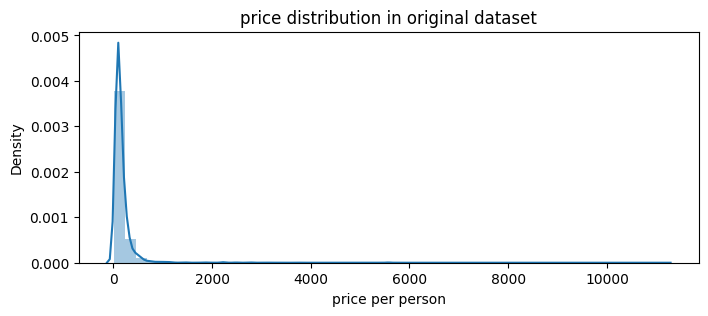

In [11]:
# calculate price statistics
print(df['price_per_person'].agg(['min','max','mean','std']))

# make plot
plt.figure(figsize=(8,3))
sns.distplot(df['price_per_person'])
#sns.displot(x='price_per_person', data=df, kde=True)
plt.title('price distribution in original dataset')
plt.xlabel('price per person')
plt.show()

percent of data removed: 2.34
min      14.000000
max     598.600000
mean    142.909099
std      99.035641
Name: price_per_person, dtype: float64


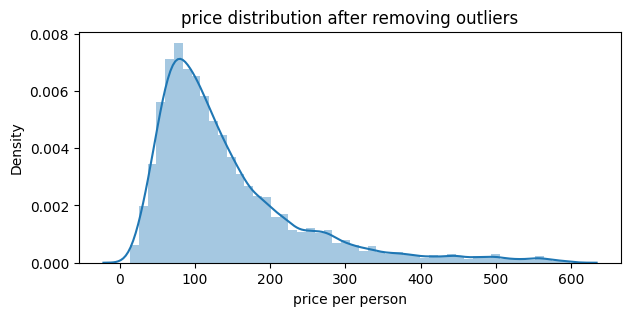

In [12]:
# remove outliers and count percent of entries removed
old_size = len(df)
df = df[df['price_per_person'] < 600]
percent_removed = round((1 - len(df)/old_size) * 100, 2)
print(f'percent of data removed: {percent_removed}')
#print(len(df))

# calculate price statistics
print(df['price_per_person'].agg(['min','max','mean','std']))

# make plot
plt.figure(figsize=(7,3))
sns.distplot(df['price_per_person'])
#sns.displot(x='price_per_person', data=df, kde=True)
plt.title('price distribution after removing outliers')
plt.xlabel('price per person')
plt.show()



#### date

min   2024-07-05
max   2025-09-02
Name: date, dtype: datetime64[ns]


<Figure size 640x480 with 0 Axes>

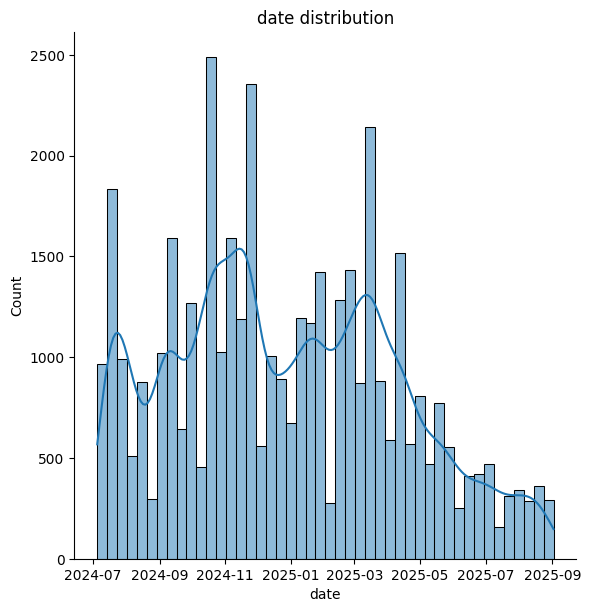

In [13]:
print(df['date'].agg(['min','max']))

plt.figure()
#sns.distplot(df['date'])
sns.displot(x='date', data=df, kde=True, height=6)
plt.title('date distribution')
plt.show()

#### number of people

min      1.000000
max     10.000000
mean     4.842042
std      2.926455
Name: adults, dtype: float64


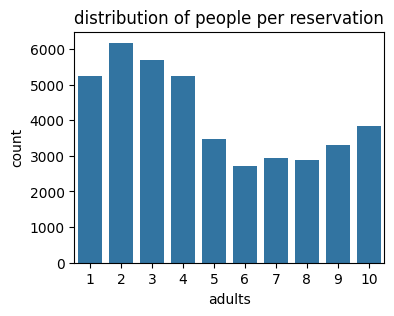

In [14]:
print(df['adults'].agg(['min','max','mean','std']))

plt.figure(figsize=(4,3))
sns.countplot(x='adults', data=df)
plt.title('distribution of people per reservation')
plt.show()

#### rating

min      4.200000
max     10.000000
mean     7.898964
std      0.863823
Name: rating, dtype: float64


<Figure size 300x300 with 0 Axes>

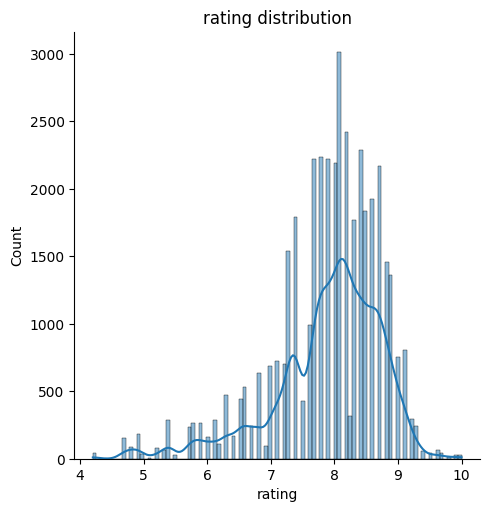

In [15]:
print(df['rating'].agg(['min','max','mean','std']))

plt.figure(figsize=(3,3))
sns.displot(x='rating', data=df, kde=True)
plt.title('rating distribution')
plt.show()

#### number of reviews

min         0.000000
max     19967.000000
mean     3424.817194
std      3474.337615
Name: opinions, dtype: float64


<Figure size 300x300 with 0 Axes>

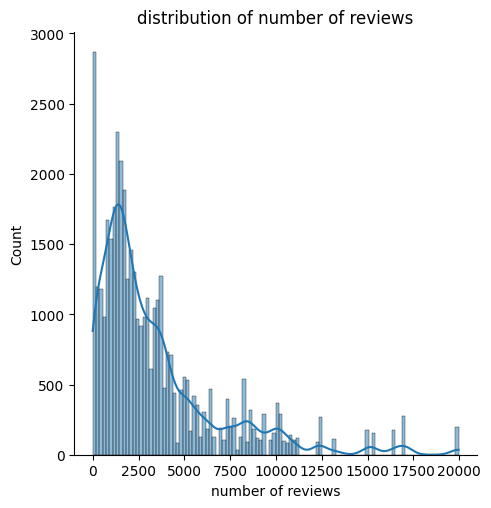

In [16]:
print(df['opinions'].agg(['min','max','mean','std']))

plt.figure(figsize=(3,3))
sns.displot(x='opinions', data=df, kde=True)
plt.title('distribution of number of reviews')
plt.xlabel('number of reviews')
plt.show()

#### stars

min     0.000000
max     5.000000
mean    2.894317
std     1.395631
Name: stars, dtype: float64


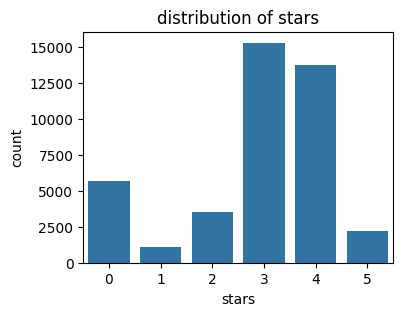

In [17]:
print(df['stars'].agg(['min','max','mean','std']))

plt.figure(figsize=(4,3))
sns.countplot(x='stars', data=df)
plt.title('distribution of stars')
plt.show()

#### distance from centre

min        50.000000
max     11000.000000
mean     2378.900752
std      2079.471110
Name: distance_from_centre, dtype: float64


<Figure size 300x300 with 0 Axes>

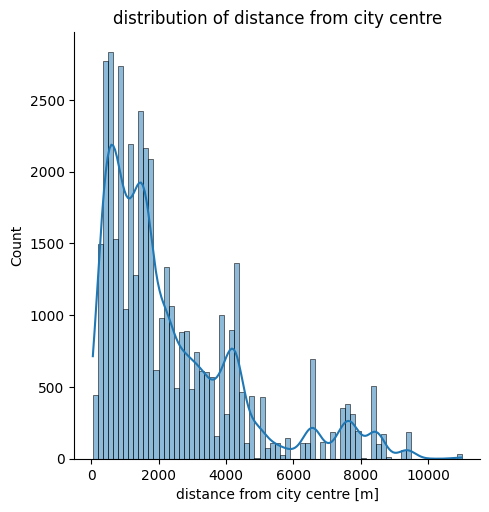

In [18]:
print(df['distance_from_centre'].agg(['min','max','mean','std']))

plt.figure(figsize=(3,3))
sns.displot(x='distance_from_centre', data=df, kde=True)
plt.title('distribution of distance from city centre')
plt.xlabel('distance from city centre [m]')
plt.show()

#### breakfast

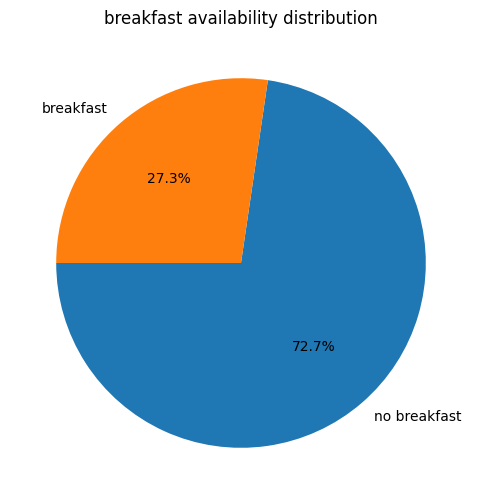

In [19]:
plt.figure(figsize=(8,6))
breakfast = len(df[df['breakfast'] == 1])
no_breakfast = len(df[df['breakfast'] == 0])
categories=[no_breakfast, breakfast]
labels = ['no breakfast', 'breakfast']
plt.pie(categories, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('breakfast availability distribution')
plt.show()

## Patterns in data

#### price per person vs number of people

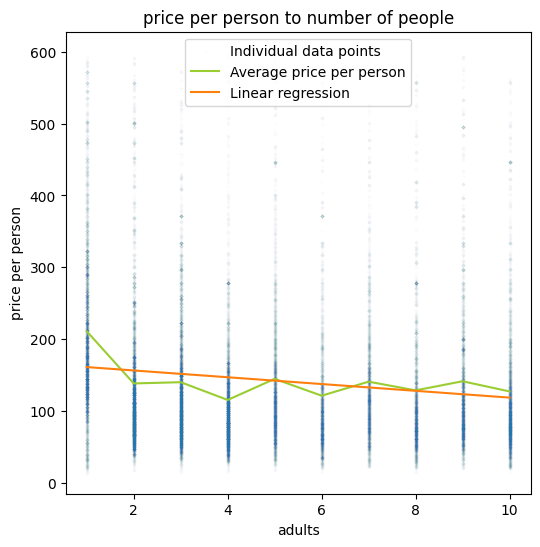

In [20]:
# Calculate the average price per person for each rating
average_prices = df.groupby('adults')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['adults'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.007)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['adults'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['adults'].min(), stop=df['adults'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to number of people')
plt.xlabel('adults')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### rating vs price per person

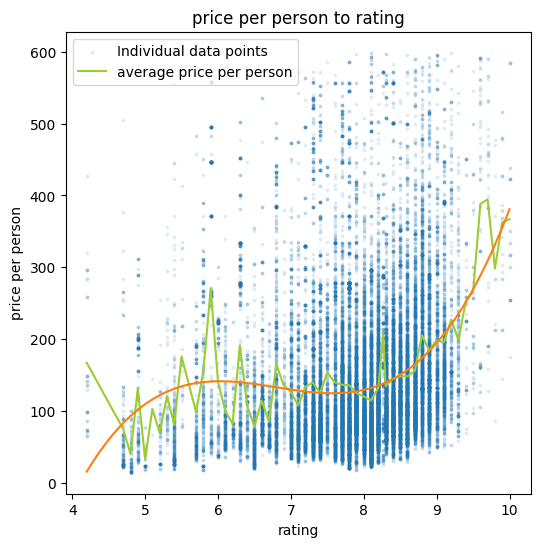

In [21]:
# Calculate the average price per person for each rating
average_prices = df.groupby('rating')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['rating'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.1)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='average price per person')

# linear regression using numpy
coef = np.polyfit(df['rating'], df['price_per_person'], 3)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['rating'].min(), stop=df['rating'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange')

plt.title('price per person to rating')
plt.xlabel('rating')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### stars vs price per person

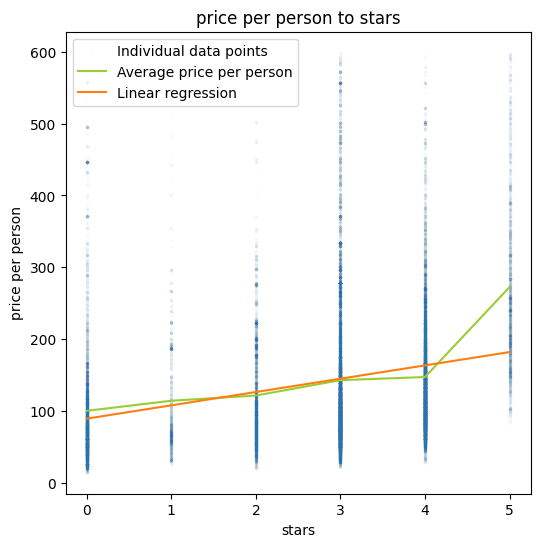

In [22]:
# Calculate the average price per person per number of stars
average_prices = df.groupby('stars')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['stars'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.01)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['stars'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['stars'].min(), stop=df['stars'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to stars')
plt.xlabel('stars')
plt.ylabel('price per person')
plt.legend()
plt.show()

<Figure size 600x600 with 0 Axes>

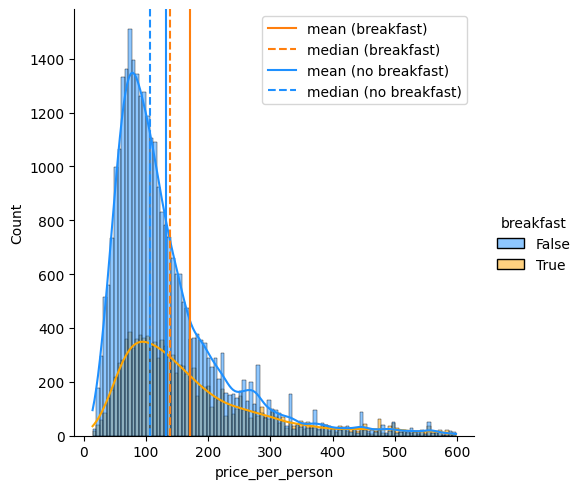

In [23]:
plt.figure(figsize=(6,6))
sns.displot(x='price_per_person', data=df, hue='breakfast', kde=True, palette = {True: 'orange', False: 'dodgerblue'})

plt.axvline(x=df[df['breakfast'] == True].price_per_person.mean(), c='tab:orange', ls='-', lw=1.5, label='mean (breakfast)')
plt.axvline(x=df[df['breakfast'] == True].price_per_person.median(), c='tab:orange', ls='--', lw=1.5, label='median (breakfast)')

plt.axvline(x=df[df['breakfast'] == False].price_per_person.mean(), c='dodgerblue', ls='-', lw=1.5, label='mean (no breakfast)')
plt.axvline(x=df[df['breakfast'] == False].price_per_person.median(), c='dodgerblue', ls='--', lw=1.5, label='median (no breakfast)')

plt.legend()
plt.show()

#### odległość od centrum a rating

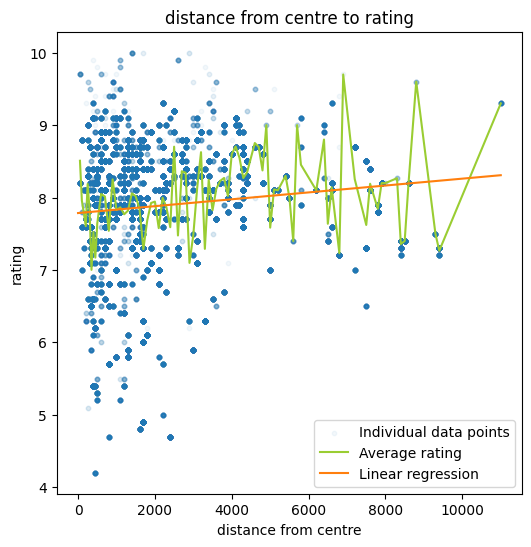

In [24]:
# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['distance_from_centre'], df['rating'], label='Individual data points', color='tab:blue', s=10, alpha=0.05)

# Calculate the average price per person for each rating
average_prices = df.groupby('distance_from_centre')['rating'].mean() 
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average rating')

# linear regression
coef = np.polyfit(df['distance_from_centre'], df['rating'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=0, stop=df['distance_from_centre'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('distance from centre to rating')
plt.xlabel('distance from centre')
plt.ylabel('rating')
plt.legend()
plt.show()

#### distance from centre vs price

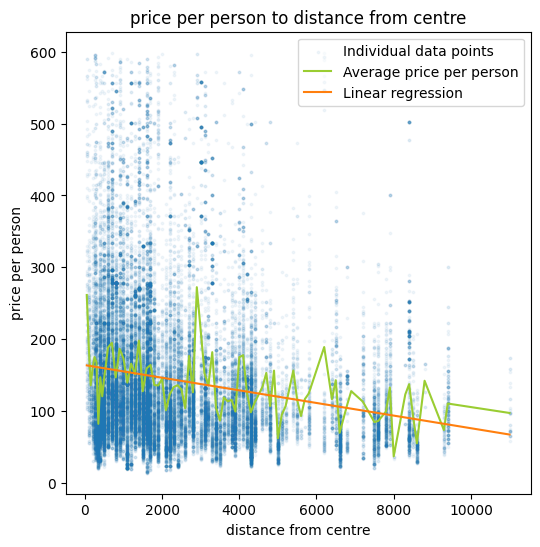

In [25]:
# Calculate the average price per person for each rating
average_prices = df.groupby('distance_from_centre')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['distance_from_centre'], df['price_per_person'], label='Individual data points', s=3, alpha=0.06)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['distance_from_centre'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['distance_from_centre'].min(), stop=df['distance_from_centre'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to distance from centre')
plt.xlabel('distance from centre')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### date vs price

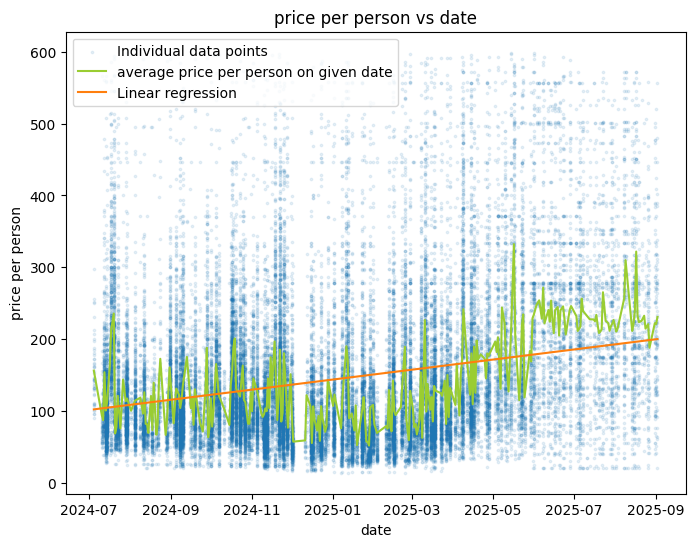

In [26]:
# Calculate the average price per person for each rating
average_prices = df.groupby('date')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(8,6))
plt.scatter(df['date'], df['price_per_person'], label='Individual data points', s=3, alpha=0.1)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='average price per person on given date')

# Calculate the difference in days from the reference date
reference_date = pd.to_datetime('2024-07-30')
days_from_reference = (df['date'] - reference_date).dt.days

# linear regression using numpy
coef = np.polyfit(days_from_reference, df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(days_from_reference.min(), days_from_reference.max(), 300)
plt.plot(reference_date + pd.to_timedelta(x, unit='D'), poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person vs date')
plt.xlabel('date')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### correllation matrix

<Axes: >

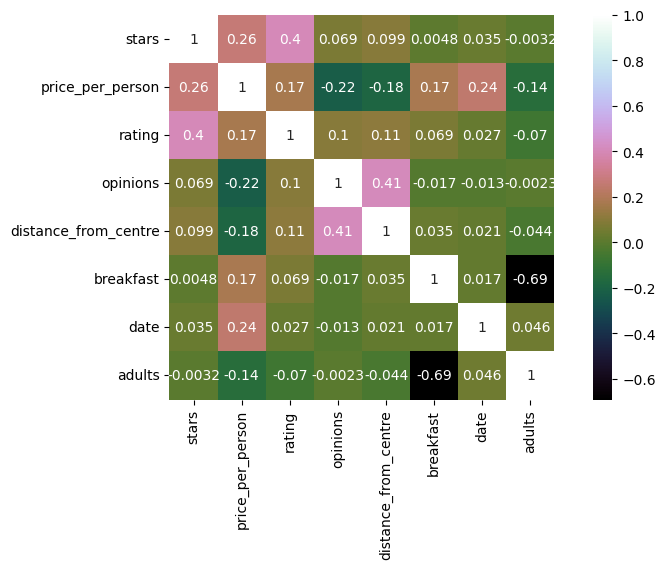

In [27]:
corr_mat=df.corr(method='pearson')
plt.figure(figsize=(10,5))
sns.heatmap(corr_mat,square=True,annot=True,cmap='cubehelix')

## Prepare data

#### split set into attributes and target

In [28]:
X = df.drop('price_per_person', axis=1)
y = df['price_per_person']

#### Scale the attributes

convert date to ordinal so it can be scaled properly

In [29]:
X['date'] = X['date'].map(datetime.toordinal)
#X['date'] = X['date'].map(lambda x: x.month)

In [30]:
#check types
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41492 entries, 0 to 42487
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stars                 41492 non-null  int64  
 1   rating                41492 non-null  float64
 2   opinions              41492 non-null  float64
 3   distance_from_centre  41492 non-null  float64
 4   breakfast             41492 non-null  bool   
 5   date                  41492 non-null  int64  
 6   adults                41492 non-null  int64  
dtypes: bool(1), float64(3), int64(3)
memory usage: 2.3 MB


In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
#print(X)

#### create training and test data set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(0,100), shuffle = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29044, 7) (12448, 7) (29044,) (12448,)


## Regression

In [33]:
results = []

In [34]:
def evaluate(y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)

    return {'mae':mae, 'mse':mse, 'r2':r2}

#### Linear Least Squares

In [35]:
# train model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['lls']))

[ 24.47923646   8.38805934 -18.026643   -15.23106621  11.88021023
  23.02831833  -6.90896398]
Mean Absolute Error (MAE): 60.94369918006106
Mean Squared Error (MSE): 7383.518014039724
R-squared (R²): 0.24116679579670264


#### Non-Negative Least Squares

In [36]:
# train model
reg = linear_model.LinearRegression(positive=True)
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['non-negative lls']))

[22.75879229  5.69154672  0.          0.         16.58675323 22.59714949
  0.        ]
Mean Absolute Error (MAE): 64.81192161918304
Mean Squared Error (MSE): 8185.997748773511
R-squared (R²): 0.15869279529201907


#### Ridge

In [37]:
# train model
reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['ridge']))

[ 24.47832428   8.38808689 -18.02616959 -15.23061299  11.87983584
  23.0275471   -6.90893404]
Mean Absolute Error (MAE): 60.943614623232776
Mean Squared Error (MSE): 7383.51897051972
R-squared (R²): 0.24116669749548925


#### Lasso

In [38]:
# train model
reg = linear_model.Lasso(alpha=1)
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['lasso']))

[ 23.66632876   7.64182172 -17.30872485 -14.28747734  11.43804323
  22.02878793  -6.18511693]
Mean Absolute Error (MAE): 60.887164190090864
Mean Squared Error (MSE): 7390.657238865189
R-squared (R²): 0.24043306956490706


polynomial least squares

In [39]:
# function to test ls for a specific degree
def poly_ls(degree: int):
    # get polynomial
    trans = PolynomialFeatures(degree)
    X_poly = trans.fit_transform(X=X_train, y=y_train)

    # train model
    reg = linear_model.LinearRegression()
    reg.fit(X_poly, y_train)

    #print(reg.coef_)

    # make predictions on the test data
    y_pred = reg.predict(trans.transform(X_test))
    results.append(pd.DataFrame(evaluate(y_pred), index=[f'ls {degree} degree']))

In [40]:
# test polynomial least squares for various degrees
degrees = [2, 3, 5, 7]
for n in degrees: poly_ls(n)

Mean Absolute Error (MAE): 51.93896345934402
Mean Squared Error (MSE): 5995.445779517544
R-squared (R²): 0.3838244421091004
Mean Absolute Error (MAE): 49.558918977163756
Mean Squared Error (MSE): 5463.494659361483
R-squared (R²): 0.4384951522258761
Mean Absolute Error (MAE): 42.73499421136239
Mean Squared Error (MSE): 4140.279427256336
R-squared (R²): 0.5744871891545689
Mean Absolute Error (MAE): 36.870820086480414
Mean Squared Error (MSE): 3169.0890234656736
R-squared (R²): 0.6743002490805574


random forest

In [41]:
def test_random_tree(n_trees: int):
    # train model
    reg = RandomForestRegressor(n_estimators=n_trees)
    reg.fit(X_train, y_train)

    #print(reg.coef_)

    # make predictions on the test data
    y_pred = reg.predict(X_test)
    results.append(pd.DataFrame(evaluate(y_pred), index=[f'random forest {n_trees} trees']))

for n in [10, 30, 100]:
    test_random_tree(n)

Mean Absolute Error (MAE): 20.92216090938303
Mean Squared Error (MSE): 1182.2087884134803
R-squared (R²): 0.8784997502216059
Mean Absolute Error (MAE): 20.13872573907455
Mean Squared Error (MSE): 1107.8393125877785
R-squared (R²): 0.8861429939339429
Mean Absolute Error (MAE): 19.615088295308478
Mean Squared Error (MSE): 1050.2276073460787
R-squared (R²): 0.8920639756130079


k-neighbours

In [42]:
def test_k_neighbors(n: int):
    # train model
    reg = KNeighborsRegressor(n_neighbors=n)
    reg.fit(X_train, y_train)

    #print(reg.coef_)

    # make predictions on the test data
    y_pred = reg.predict(X_test)
    results.append(pd.DataFrame(evaluate(y_pred), index=[f'k-neighbours [{n}]']))

for n in [1, 2, 3, 4, 5]:
    test_k_neighbors(n)

Mean Absolute Error (MAE): 31.217230880462722
Mean Squared Error (MSE): 3298.0365600016066
R-squared (R²): 0.6610478032765893
Mean Absolute Error (MAE): 31.711799887532134
Mean Squared Error (MSE): 2923.8845604334033
R-squared (R²): 0.6995008767507164
Mean Absolute Error (MAE): 32.923245769065986
Mean Squared Error (MSE): 2957.3216797656028
R-squared (R²): 0.6960644124048674
Mean Absolute Error (MAE): 34.24288921915167
Mean Squared Error (MSE): 3055.5536983782536
R-squared (R²): 0.6859687212590674
Mean Absolute Error (MAE): 35.22112965938303
Mean Squared Error (MSE): 3160.2559219328405
R-squared (R²): 0.6752080616878358


In [43]:
results_df = pd.concat(results)
results_df

,mae,mse,r2
lls,60.943699,7383.518014,0.241167
non-negative lls,64.811922,8185.997749,0.158693
ridge,60.943615,7383.518971,0.241167
lasso,60.887164,7390.657239,0.240433
ls 2 degree,51.938963,5995.445780,0.383824
ls 3 degree,49.558919,5463.494659,0.438495
ls 5 degree,42.734994,4140.279427,0.574487
ls 7 degree,36.870820,3169.089023,0.674300
random forest 10 trees,20.922161,1182.208788,0.878500
random forest 30 trees,20.138726,1107.839313,0.886143


Text(0, 0.5, 'model')

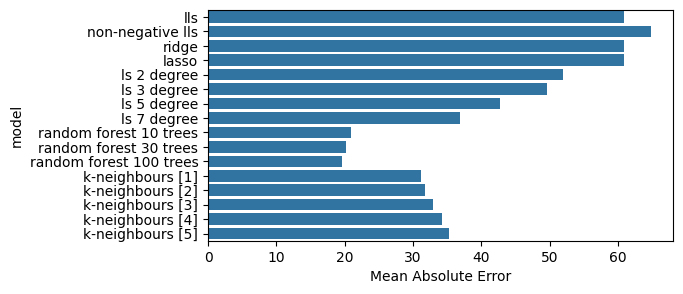

In [44]:
plt.figure(figsize= (6, 3))
sns.barplot(y=results_df.index, x=results_df.mae)
plt.xlabel('Mean Absolute Error')
plt.ylabel('model')

Text(0, 0.5, 'model')

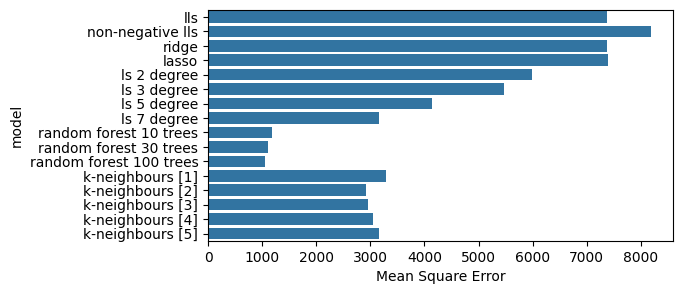

In [45]:
plt.figure(figsize= (6, 3))
sns.barplot(y=results_df.index, x=results_df.mse)
plt.xlabel('Mean Square Error')
plt.ylabel('model')

Text(0, 0.5, 'model')

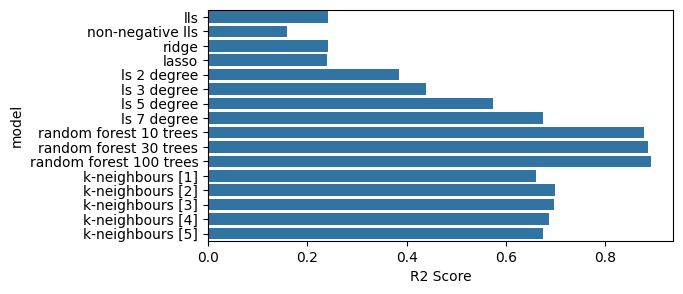

In [46]:
plt.figure(figsize= (6, 3))
sns.barplot(y=results_df.index, x=results_df.r2)
plt.xlabel('R2 Score')
plt.ylabel('model')